<a href="https://colab.research.google.com/github/FabriceBeaumont/1-MA-INF_2314_IPSA_Repo/blob/main/Code/Exercise4/SolutionsOfSheet4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IPSA 2021 - Exercise 4 - Fourier Transforms and Gaussian filters

## 0 - Practical Advice

In [8]:
import imageio 
import numpy as np
import numpy.fft as fft
import numpy.random as rnd
import scipy.ndimage as img
import scipy.interpolate as ipl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
import timeit, functools

In [ ]:
def imageScaleRange(f, vmin=0, vmax=255):
    """Stretches the intensity values of a given image array f 
    such that they cover the whole range from 0 to 255"""
    return np.interp(f, (f.min(), f.max()), (vmin, vmax))

def imageRead(imgname, pilmode ='L', arrtype=float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

In [39]:
def writeFigure(fig, fname):
    fmt = fname.split('.')[-1]
    fig.savefig(fname, facecolor=fig.get_facecolor(), edgecolor='w',
                papertype='letter', format=fmt, transparent=False,
                bbox_inches='tight', pad_inches=0)

def plotFcts(x, fs,
             labs=None, lfs='x-small',
             xtcs=None, ytcs=None,
             lims=None, fname=None, title=None):

    # Initialize figure and axes.
    fig = plt.figure()
    axs = fig.add_subplot(211, facecolor='w')

    # Nicer way of showing coordinate axes.
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        
    # Plot the function.
    for f in fs:
        axs.plot(x, f, '-', alpha=0.75)

    # Plot the legend.
    if labs is not None:
        axs.legend(labs, loc="upper right", fontsize=lfs,
                   facecolor='#e0e0e0', edgecolor='k', fancybox=False)

    if xtcs is not None: axs.set_xticks(xtcs)
    if ytcs is not None: axs.set_yticks(ytcs)
    
    if lims is not None:
        axs.set_xlim(lims[0], lims[1])
        axs.set_ylim(lims[2], lims[3])
        
    if title:
        plt.title(title)
        
        
    # Show figure on screen or write it to disc.
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

def plotShapeFct(Z, closed=True, lw=1, ms=2, mew=0, al=0.75, fname=None, title=None):
    # Initialize figure and axes.
    fig = plt.figure()
    axs = fig.add_subplot('111', facecolor='w')
    axs.set_aspect(aspect='equal')
    
    # Nicer way of showing coordinate axes.
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        

    if closed:
        Z = np.hstack((Z, Z[0]))
        
    X = Z.real
    Y = Z.imag

    # Plot dottet or as line - depending on the 'closed'-flag.
    if closed:
        axs.plot(X, Y, '-', lw=lw, alpha=al)
    else:
        axs.plot(X, Y, 'o', ms=ms, mew=mew, alpha=al)

    xmin, xmax = min(-1, np.min(X)-1), np.max(X)+1
    ymin, ymax = min(-1, np.min(Y)-1), np.max(Y)+1
    
    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin, ymax)

    if title:
        plt.title(title)

    # Show figure on screen or write it to disc.
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

    return fig

## 1 - Plotting boundaries of shape images

In the Data folder for this exercise, you will find the data file `hand.csv` which contains a data matrix $X\in\mathbb{R}^{2\times 537}$ whose columns $x_k = [x_k , y_k ]^\intercal$ represent 2D points. If you plot these data points using individual dots or a closed line.

![dot_and_line.png](attachment:dot_and_line.png)

To read these data into a numpy array `matX` representing matrix $X$, you may proceed as follows:

In [ ]:
matX = np.loadtxt('hand.csv', delimiter=', ')

# Assemble the values in a vector of complex numbers.
vecZ = matX[0] + 1j * matX[1]

In [ ]:
print(matX)

[[59. 60. 61. ... 56. 57. 58.]
 [ 3.  3.  3. ...  4.  4.  4.]]


In [ ]:
print(vecZ)

[ 59.  +3.j  60.  +3.j  61.  +3.j  61.  +4.j  61.  +5.j  62.  +6.j
  63.  +6.j  63.  +7.j  64.  +8.j  65.  +8.j  66.  +9.j  67. +10.j
  68. +11.j  69. +11.j  70. +11.j  71. +10.j  72. +11.j  73. +11.j
  74. +12.j  75. +13.j  76. +14.j  77. +14.j  78. +15.j  79. +16.j
  80. +16.j  81. +17.j  82. +18.j  83. +19.j  84. +19.j  84. +20.j
  85. +21.j  86. +21.j  86. +22.j  87. +23.j  88. +24.j  89. +25.j
  90. +26.j  91. +27.j  92. +27.j  92. +28.j  92. +29.j  93. +30.j
  94. +31.j  95. +32.j  96. +33.j  97. +33.j  97. +34.j  98. +35.j
  99. +36.j 100. +37.j 101. +37.j 101. +38.j 102. +39.j 103. +39.j
 103. +40.j 104. +41.j 105. +42.j 106. +43.j 107. +43.j 108. +43.j
 109. +44.j 110. +45.j 111. +46.j 112. +46.j 113. +47.j 114. +48.j
 114. +49.j 114. +50.j 114. +51.j 113. +52.j 112. +52.j 111. +53.j
 110. +53.j 109. +54.j 108. +54.j 107. +54.j 106. +53.j 105. +53.j
 104. +53.j 103. +53.j 102. +53.j 101. +52.j 100. +52.j  99. +51.j
  98. +50.j  97. +50.j  96. +49.j  95. +48.j  94. +48.j  93. +

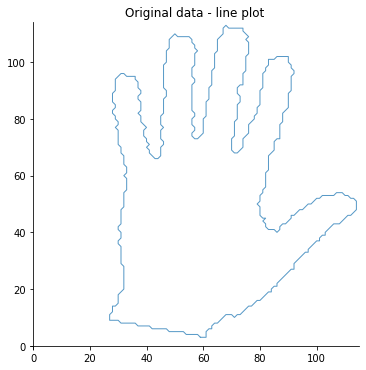

In [ ]:
# Lets plot the shape with a continuous line.
plotShapeFct(vecZ, closed=True, title="Original data - line plot")

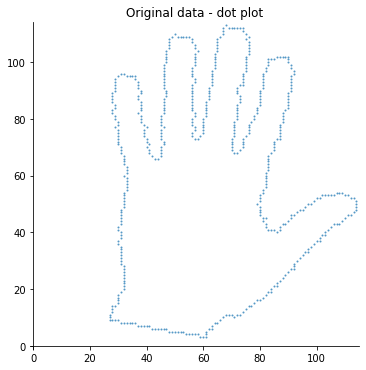

In [ ]:
# Lets plot the shape with a dotted line.
plotShapeFct(vecZ, closed=False, title="Original data - dot plot")

Now, center the data in $X$, i.e. determine the the mean $\hat{x}$ of the data points $x_k$ and transform them as follows:
$$  x_k  \leftarrow \quad x_k - \hat{x} $$

Then create a dot plot and a line plot of the centered data (including coordinate axes).

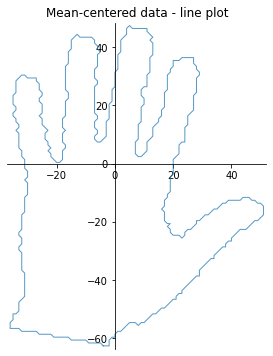

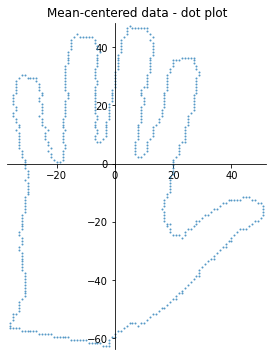

In [ ]:
# Shift the data my its mean. Compute the mean over the two rows (real and imaginary).
matXh = matX - np.mean(matX, axis=1).reshape(2,1)

# Again, assemble the values in a vector of complex numbers.
# The first row of 'matXh' contains the centered real values, the second the imaginary ones.
vecZ = matXh[0] + 1j * matXh[1]

plotShapeFct(vecZ, closed=True, title="Mean-centered data - line plot")
plotShapeFct(vecZ, closed=False, title="Mean-centered data - dot plot")

## 2 - Interpolating boundaries of shape images

In what follows, we will work with the centered data matrix $\hat{X}$ which you computed in the previous task and we will assume that is  available in a 2D numpy array `matXh`.

Recall that this matrix contains $n = 537$ column vectors $x_k = [x_k , y_k ]^\intercal$.
Given these $n$ data points, we will now interpolate $N$. Without further ado, this can be accomplished as follows:

In [ ]:
# Get the data point of the shape ('matXh[:,0]') and stack it to all others.
# This way 'matXh' now contains a closed loop.
matXh = np.hstack((matXh, matXh[:,0].reshape(2,1)))
# Get as many numbers from [0, 2pi] as there are datapoints.
stps = np.linspace(0, 2*np.pi, matXh.shape[1])
# Now interpolate the real and imaginary values using these numbers.
iplx = ipl.interp1d(stps, matXh[0], kind='cubic')
iply = ipl.interp1d(stps, matXh[1], kind='cubic')

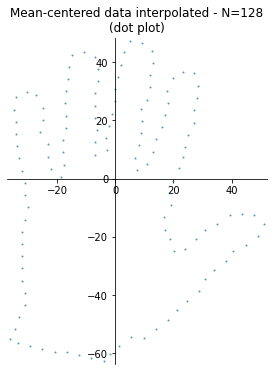

In [ ]:
N = 128
# Using the defined interpolation functions 'iplx' and 'iply', 
# reassamble the shape by using 'N' points to evaluate the interpolations. 
matXi = np.vstack((iplx(np.linspace(0, 2*np.pi, N, endpoint=False)), iply(np.linspace(0, 2*np.pi, N, endpoint=False))))
vecZ = matXi[0] + 1j * matXi[1]

# Plot the interpolations.
plotShapeFct(vecZ, closed=False, title=f"Mean-centered data interpolated - N={N}\n(dot plot)")

Create plots dot- and line for the cases where for $N = \{256, 512\}$.

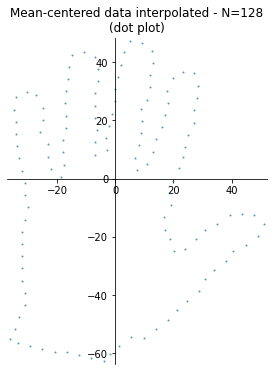

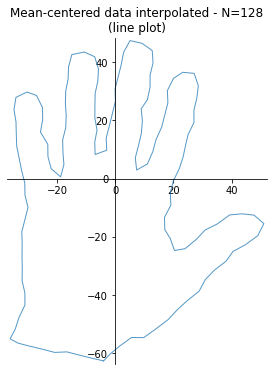

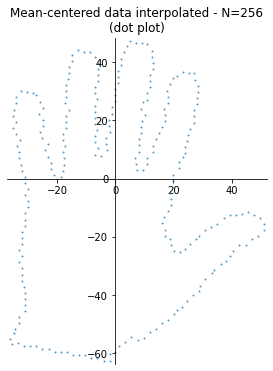

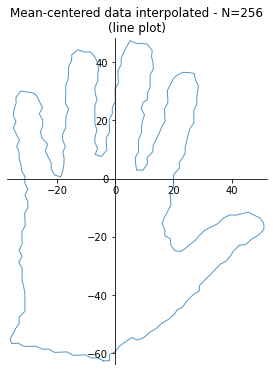

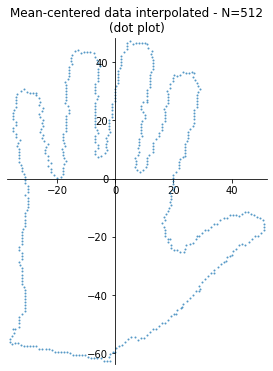

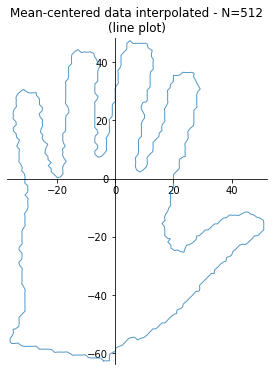

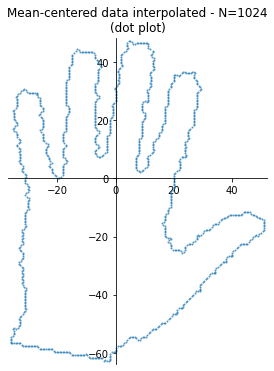

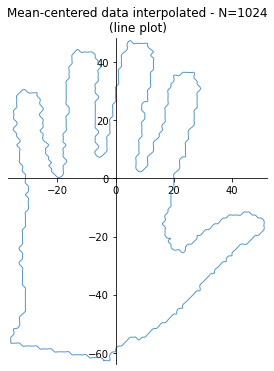

In [ ]:
# Execute the interpolation for different numbers of evaluations 'N'.
for i, N in enumerate([128, 256, 512, 1024]):
    ts = np.linspace(0, 2*np.pi, N, endpoint=False)
    xs = iplx(ts)
    ys = iply(ts)
    
    vecZ = xs + 1j * ys

    plotShapeFct(vecZ, closed=False, title=f"Mean-centered data interpolated - N={N}\n(dot plot)")
    plotShapeFct(vecZ, closed=True, title=f"Mean-centered data interpolated - N={N}\n(line plot)")

## 3 - Fourier transforms of periodic complex valued functions

Note that we can alternatively think of the 2D data points $x_k = [x_k , y_k ]^\intercal$ from the previous tasks in terms of complex numbers
$$ z_k = x_k + i y_k $$

Also note that we can therefore think of our use of `ipl.interp1d` in the previous task as having created a continuous function $f:[0, 2\pi ) \to C$ which we then sampled at points $j · \frac{2\pi}{N}$ where $j = 0, \dots , N − 1$ to obtain a vector or 1D array 
$$ z = [ z_0, z_1 , \dots z_{N-1}] $$

where $z_j = f\big( j\frac{2\pi}{N} \big)$.

Finally, note that we may think of array $z$ as the values of one period of the discrete periodic function $f[j] = f \big( j\frac{2\pi}{N} \big)$ where $j = J \: \text{mod}(N)$ and $J\in\mathbb{Z}$.

To compute array $z$ in practice, i.e. not just conceptually, you may reuse your results from the previous task. Letting $N = 256$, recompute array `arrXi` and then execute

    arrZ = matXi[0] + 1j * matXi[1]

Now compute the Fourier transform of array $z$ and low pass filter it with cut-off frequencies $\omega_l\in \{2, 4\}$. (Remember our discussion of `fft.fftfreq` in *lecture 10* and of `fft.fftshift` and `fft.ifftshift` in *lecture 11*.)

### Solution using the interpolation and [`i`]`fftshift`

In [34]:
N = 256
# Load the data.
matX  = np.loadtxt('hand.csv', delimiter=', ')
# Center the data.
matXh = matX - np.mean(matX, axis=1).reshape(2,1)
# Copy the first datapoint to the end and stack the datapoints horizontally.
matXh = np.hstack((matXh, matXh[:,0].reshape(2,1)))

# Again get evenly spaced evaluation point in [0, 2pi] and define the interpolation functions.
stps  = np.linspace(0, 2*np.pi, matXh.shape[1])
iplx  = ipl.interp1d(stps, matXh[0], kind='cubic')
iply  = ipl.interp1d(stps, matXh[1], kind='cubic')

# Assemble the interpolation.
matXi = np.vstack((iplx(np.linspace(0, 2*np.pi, N, endpoint=False)),
                    iply(np.linspace(0, 2*np.pi, N, endpoint=False))))
arrZ = matXi[0] + 1j * matXi[1]

In [35]:
# Define the omega as the Fourier Transform to use it as a low pass filter.
w = fft.fftshift(fft.fftfreq(N, 2*np.pi/N))

# Compute the Fourier Transform of the interpolated shape.
fftZ = fft.fftshift(fft.fft(arrZ))

Compute the inverse Fourier transform of the filtered signal and create line plots of your results. To see how these should look like, here are results for $\omega_l\in \{0.5, 1.0\}$.

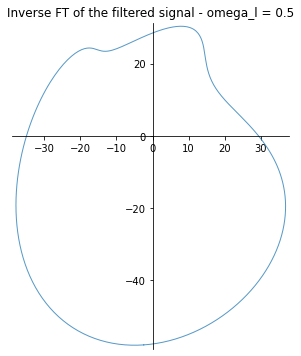

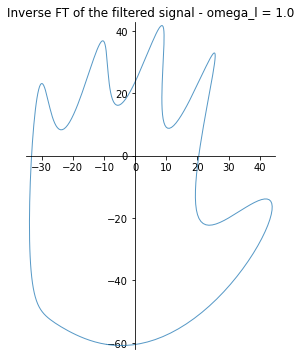

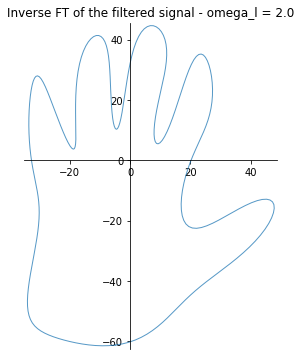

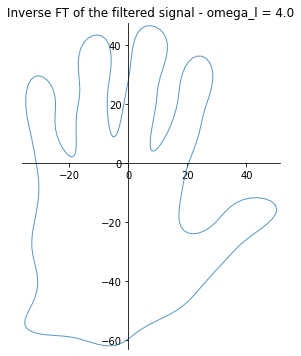

In [36]:
for i, cutoff in enumerate([0.5, 1.0, 2.0, 4.0]):
    # Define the cutoff-mask based on the Fourier Transform omega.
    fftG = np.where(np.abs(w)<=cutoff, 1, 0)
    # Apply the binary cutoff (it is in {1,0}) to the Fourier Transform.
    fftS = fftZ * fftG
    # Compute the inverse Fourier Transform to get an image back.
    arrS = fft.ifft(fft.ifftshift(fftS))

    # Plot the shape.
    plotShapeFct(arrS, closed=True, title=f"Inverse FT of the filtered signal - omega_l = {cutoff}")

### Solution using the interpolation **but not** [`i`]`fftshift`

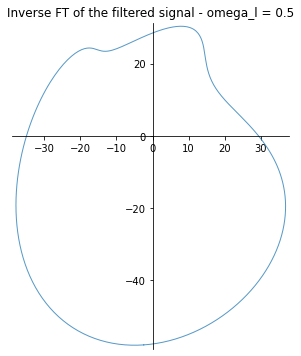

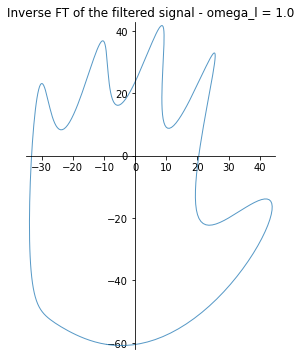

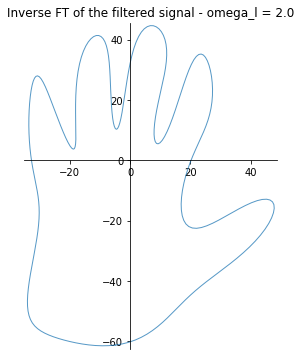

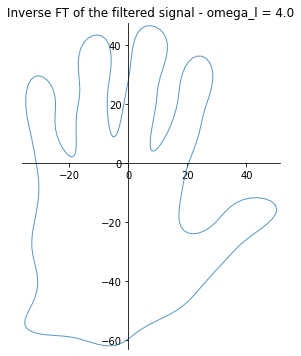

In [37]:
# Load the data.
N = 256
matX  = np.loadtxt('hand.csv', delimiter=', ')
# Center the data.
matXh = matX - np.mean(matX, axis=1).reshape(2,1)
# Copy the first datapoint to the end and stack the datapoints horizontally.
matXh = np.hstack((matXh, matXh[:,0].reshape(2,1)))

# Again get evenly spaced evaluation point in [0, 2pi] and define the interpolation functions.
stps  = np.linspace(0, 2*np.pi, matXh.shape[1])
iplx  = ipl.interp1d(stps, matXh[0], kind='cubic')
iply  = ipl.interp1d(stps, matXh[1], kind='cubic')

# Assemble the interpolation.
matXi = np.vstack((iplx(np.linspace(0, 2*np.pi, N, endpoint=False)),
                    iply(np.linspace(0, 2*np.pi, N, endpoint=False))))
arrZ = matXi[0] + 1j * matXi[1]

# Define the omega as the Fourier Transform to use it as a low pass filter.
w = fft.fftfreq(N, 2*np.pi/N)

# Compute the Fourier Transform of the interpolated shape.
fftZ = fft.fft(arrZ)

for i, cutoff in enumerate([0.5, 1.0, 2.0, 4.0]):
    # Define the cutoff-mask based on the Fourier Transform omega.
    fftG = np.where(np.abs(w)<=cutoff, 1, 0)
    # Apply the binary cutoff (it is in {1,0}) to the Fourier Transform.
    fftS = fftZ * fftG
    # Compute the inverse Fourier Transform to get an image back.
    arrS = fft.ifft(fftS)

    # Plot the shape.
    plotShapeFct(arrS, closed=True, title=f"Inverse FT of the filtered signal - omega_l = {cutoff}")

### Solution using neither a interpolation, nor the [`i`]`fftshift`

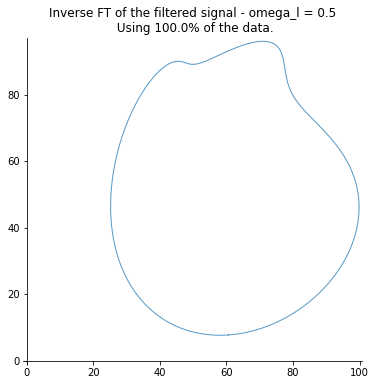

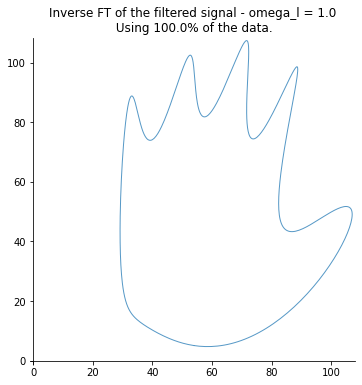

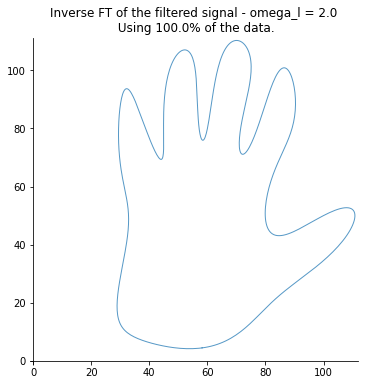

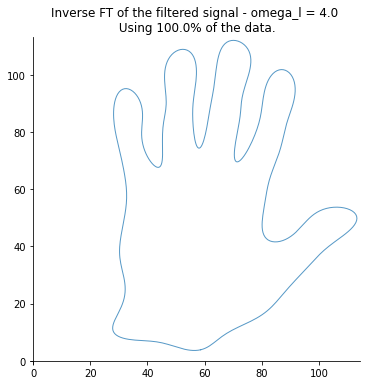

In [48]:
N = 256
# Load the data.
matX = np.loadtxt('hand.csv', delimiter=', ')

# Lets define a limit, such that we can use only a percentage of the given data. (Just for fun.)
used_data_percentage = 1.0
data_limit = int((len(matX[0]))*used_data_percentage)
arrZ = (matX[0] + 1j * matX[1])[:data_limit]

# Define the omega as the Fourier Transform to use it as a low pass filter.
# Since 'arrZ' may no longer have length 'N', make 'w' dependent on its length.
w = fft.fftfreq(len(arrZ), 2*np.pi/len(arrZ))

# Compute the Fourier Transform of the interpolated shape.
fftZ = fft.fft(arrZ)

for i, cutoff in enumerate([0.5, 1.0, 2.0, 4.0]):
    # Define the cutoff-mask based on the Fourier Transform omega.
    fftG = np.where(np.abs(w)<=cutoff, 1, 0)
    # Apply the binary cutoff (it is in {1,0}) to the Fourier Transform.
    fftS = fftZ * fftG
    # Compute the inverse Fourier Transform to get an image back.
    arrS = fft.ifft(fftS)

    # Plot the shape.
    plotShapeFct(arrS, closed=True, title=f"Inverse FT of the filtered signal - omega_l = {cutoff}\n Using {used_data_percentage*100}% of the data.")

## 4 Gaussian filtering in practice

In the Data folder for this exercise, you will find the intensity image `cat.png`. Read it into a numpy array $arrF$.

In the lecture we discussed Gaussian filtering in the space domain and saw that we can think of the process as moving a corresponding filter
mask across the image to be filtered. Back then, the question arose how to handle pixels close to the boundary of the image and your instructor
said not to obsess about this issue...

Indeed, Gaussian filtering is such a common task that `scipy` has us covered. Its `ndimage` module contains the function gaussian filter which you may use like this:

    sigm = 7.
    arrH = img.gaussian_filter(arrF, sigma=sigm, mode='constant')

Note, however, that constant is not the only possible value for parameter mode. This parameter tell the function how to handle the “boundary pixel problem” and if you read the scipy manual, you will find that it can also be
set to reflect, mirror, nearest,...

Consider $\sigma \in \{1, 3, 9\}$ and the mode parameters just mentioned to compute filtered images $arrH$. Write these images as PNG files.

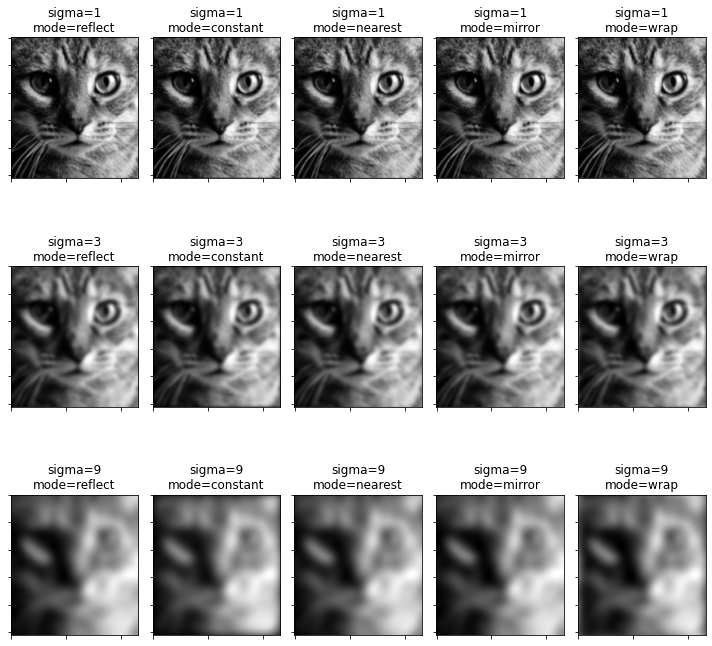

In [ ]:
arrF = imageRead('cat.png')
sigmas = [1, 3, 9]
modes = ['reflect', 'constant', 'nearest', 'mirror', 'wrap']

fig, axs = plt.subplots(len(sigmas), len(modes), figsize=(10,10))

for i, sigma in enumerate(sigmas):
    for j, mode in enumerate(modes):
        
        if mode == 'constant':
            # Use 'cval' to specify the constant value that is assumed outside of the picture.
            arrH =  img.gaussian_filter(arrF, sigma=sigma, mode=mode, cval=0)
        else: 
            arrH =  img.gaussian_filter(arrF, sigma=sigma, mode=mode)

        # Plot the image.
        axs[i][j].imshow(arrH, cmap='gray')
        axs[i][j].set_title(f"sigma={sigma}\nmode={mode}")
        axs[i][j].set_xticklabels([]); axs[i][j].set_yticklabels([]);

fig.tight_layout()
plt.show()

What do you observe? Does the manner in which images boundaries are handled make a huge difference in practice?

In these cases, the differences between the modes are barely noticable. "*The mode parameter determines how the input array is extended when the filter overlaps a border.*"

**Reflect**: "*The input is extended by reflecting about the edge of the last pixel*". 

**Constant**: "*The input is extended by filling all values beyond the edge with the same constant value, defined by the `cval` parameter*" (here zero values).
The effect is most noticable with a lot of blurr ($\sigma=9$): The borders are darker since the dark pixels around the image effect their neighboring pixels in the image.

**Nearest**: "*The input is extended by replicating the last pixel.*"

**Mirror**: "*The input is extended by reflecting about the center of the last pixel.*"

**Wrap**: "*The input is extended by wrapping around to the opposite edge.*"

Reference: [scipy.ndimage.gaussian_filter.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)